# FIBAD Demonstration

For this demonstration we'll walk through a simplified version of a typical machine learning workflow supported by FIBAD.

## Download a sample HSC dataset

In [4]:
import pooch

file_path = pooch.retrieve(
    # DOI for Example HSC dataset
    url="doi:10.5281/zenodo.14498536/hsc_demo_data.zip",
    known_hash="md5:1be05a6b49505054de441a7262a09671",
    fname="example_hsc_new.zip",
    path="../../data",
    processor=pooch.Unzip(extract_dir="."),
)

This dataset is comprised of approximately 993 cutouts from the Hyper Suprime Cam survey.
Each cutout includes i, r and g bands and is 8 arcseconds on a side.


## Creating and configuring a FIBAD object

In [152]:
import fibad
f = fibad.Fibad()

[2025-01-30 21:48:29,005 fibad:INFO] Runtime Config read from: /home/drew/code/fibad/src/fibad/fibad_default_config.toml


After importing fibad and create a new fibad object.

Under the hood the Fibad instance is preparing it's environment, it will:
-  Load the configuration file specified (here it's using the built in default).
-  Parse the configuration file for external libraries and add those to the appropriate registries.
-  Prepare logging for the system.

In [153]:
# Specify the location of the data to use for training
f.config["general"]["data_dir"] = "../../data/hsc_8asec_1000_bu"

# Specify the dataset class that represents the data
f.config["data_set"]["name"] = "HSCDataSet"

# Select the model to use for training
f.config["model"]["name"] = "ExampleAutoencoder"

# Set the number of epochs and batch size for training.
f.config["train"]["epochs"] = 1
f.config["data_loader"]["batch_size"] = 32

The default configuration needs a few tweaks to work for this demo.
We've updated the location of our sample data, and specified which model we want to train.

The configuration is represented as nested python dictionary. This allows for easy manipulation in a notebook vai the `.config` attribute of the fibad instance.

## Training a model

In [154]:
f.train()

[2025-01-30 21:48:31,624 fibad.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-01-30 21:48:31,625 fibad.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-01-30 21:48:31,628 fibad.data_sets.hsc_data_set:INFO] HSC Data set loader has 993 objects
[2025-01-30 21:48:31,632 fibad.data_sets.hsc_data_set:INFO] test split contains 199 items
[2025-01-30 21:48:31,633 fibad.data_sets.hsc_data_set:INFO] train split contains 596 items
[2025-01-30 21:48:31,633 fibad.data_sets.hsc_data_set:INFO] validate split contains 198 items
[2025-01-30 21:48:31,644 fibad.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
2025-01-30 21:48:31,646 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fibad.data_sets.hsc': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x7f98004e1ca0>, 'batch_size': 32, 'num_workers': 2, 'pin_memory': True}
2025-01-30 21:4

2025/01/30 21:48:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
[2025-01-30 21:48:31,690 fibad.pytorch_ignite:INFO] Training model on device: cuda
[2025-01-30 21:48:31,691 fibad.pytorch_ignite:INFO] Total epochs: 1
[2025-01-30 21:48:35,026 fibad.pytorch_ignite:INFO] Total training time: 3.34[s]
[2025-01-30 21:48:35,027 fibad.pytorch_ignite:INFO] Latest checkpoint saved as: /home/drew/code/fibad/results/20250130-214831-train-cn8s/checkpoint_epoch_1.pt
[2025-01-30 21:48:35,028 fibad.pytorch_ignite:INFO] Best metric checkpoint saved as: /home/drew/code/fibad/results/20250130-214831-train-cn8s/checkpoint_1_loss=-1077.9679.pt
2025/01/30 21:48:35 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/30 21:48:35 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-01-30 21:48:35,692 fibad.train:INFO] Finished Training


We call the `.train()` method to train the model

The output of the training will be stored in a time-stamped directory under the `./results/`. By default, a copy of the final configuration used in training is persisted as `runtime_config.toml`. To run fibad again with the same configuration, you can reference the runtime_config.toml file.

If running in another notebook, instantiate a fibad object like so:
```
new_fibad_instance = fibad.Fibad(config_file='./results/<timestamped_directory>/runtime_config.toml')
```

Or from the command line on an HPC system:
```
>> fibad train --runtime-config ./results/<timestamped_directory>/runtime_config.toml
```

## Create a new model

New models can be written in a notebook for easier development.
Here an autoencoder is written for comparison against the builtin `ExampleAutoencoder`.

For reference, the primary difference is that the builtin autoencoder uses `nn.GeLU` whereas `nn.ReLU` is used here.

In [19]:
import torch.nn as nn
import torch.optim as optim
from fibad.models.model_registry import fibad_model


@fibad_model  # This decorator registers the model with the FIBAD framework
class TrialAutoencoder(nn.Module):
    def __init__(self, config, shape):
        super().__init__()
        self.config = config

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (16, 48, 48)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 24, 24)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 12, 12)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 6, 6)
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 12, 12)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 24, 24)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16, 48, 48)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (3, 96, 96)
            nn.Sigmoid(),  # Normalize output to [0, 1]
        )

    def _eval_encoder(self, x):
        return self.encoder(x)

    def _eval_decoder(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self._eval_encoder(x)

    def train_step(self, x):
        z = self._eval_encoder(x)
        x_hat = self._eval_decoder(z)

        # Here, the loss function is defined in the config
        loss = self.criterion(x, x_hat)
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return {"loss": loss.item()}

    # The optimizer can be coded directly, or defined in the configuration file
    def _optimizer(self):
        return optim.Adam(self.parameters(), lr=1e-3)

With the model defined in the notebook and registered with Fibad using the `@fibad_model` decorator, the configuration
is updated so that in the next call to `f.train()` the new model will be used.

Fibad is quite extensible. The above example shows how an externally defined model can be easily registered with Fibad to inherit boilerplate code to minimize user effort when developing new models.
In addition to this Fibad exposes a `@fibad_data_set` decorator to assist with the development of new and experimental data sets.

Next we update the configuration to use the newly defined model for training.
Note that we can define the loss function definitions in the configuration for easy exploration of those hyperparameters.
While it's not shown here, a similar mechanism can be used for defining the optimizer function.


In [155]:
# We specify that we now want to train the model defined in the previous cell
f.config["model"]["name"] = "TrialAutoencoder"

# Define a loss function via the configuration file for easy experimentation
f.config["criterion"]["name"] = "torch.nn.MSELoss"
f.config["torch.nn.MSELoss"] = {
    "reduction": "none"
}

In [156]:
f.train()

[2025-01-30 21:58:43,438 fibad.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-01-30 21:58:43,439 fibad.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-01-30 21:58:43,441 fibad.data_sets.hsc_data_set:INFO] HSC Data set loader has 993 objects
[2025-01-30 21:58:43,445 fibad.data_sets.hsc_data_set:INFO] test split contains 199 items
[2025-01-30 21:58:43,445 fibad.data_sets.hsc_data_set:INFO] train split contains 596 items
[2025-01-30 21:58:43,446 fibad.data_sets.hsc_data_set:INFO] validate split contains 198 items


[2025-01-30 21:58:43,451 fibad.models.model_registry:INFO] Using criterion: torch.nn.MSELoss with arguments: {'reduction': 'none'}.
2025-01-30 21:58:43,453 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fibad.data_sets.hsc': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x7f9800ae0230>, 'batch_size': 32, 'num_workers': 2, 'pin_memory': True}
2025-01-30 21:58:43,453 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fibad.data_sets.hsc': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x7f98004557c0>, 'batch_size': 32, 'num_workers': 2, 'pin_memory': True}
2025/01/30 21:58:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
[2025-01-30 21:58:43,489 fibad.pytorch_ignite:INFO] Training model on device: cuda
[2025-01-30 21:58:43,490 fibad.pytorch_ignite:INFO] Total epochs: 1
[2025-01-30 21:58:46,837 fibad.pytorch_ignite:INFO] Total training 

The results of model training and saved in the `./results` directory. We can see that as we've run these several times, and there are timestamped directories

### /// Include a screen shot of the directory strucutre


## Compare model performance

Fibad will automatically logs training information for model evaluation.
Currently Tensorboard and MLFlow are supported for easy model-to-model comparisons of metrics and parameters.

![alt text](mlflow_mpr_training_loss.JPG)
![alt text](mlflow_mpr_param_diffs.JPG)


In [22]:
%reload_ext tensorboard
%tensorboard --logdir ./results

Reusing TensorBoard on port 6006 (pid 3426), started 0:01:17 ago. (Use '!kill 3426' to kill it.)

## Running inference using a trained model
Once a model has been trained, we can use the model weights file to run inference on.

In this example, we'll assume that the the builtin `ExampleAutoencoder` has outperformed the `TrialAutoencoder` defined in the notebook.

In order to run inference using a specific trained model, the `'infer'` configuration section is updated.
Additionally, to run inference on the entire dataset the data set splits are updated.

In [23]:
# Update the data set splits to be 100% test data
f.config["data_set"]["test_size"] = 1.0
f.config["data_set"]["train_size"] = 0.0
f.config["data_set"]["validate_size"] = 0.0

# Increase batch size for faster inference
f.config["data_loader"]["batch_size"] = 512

The following will run inference on the specified dataset.

In [24]:
f.infer()

[2025-01-29 21:16:02,044 fibad.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-01-29 21:16:02,045 fibad.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-01-29 21:16:02,048 fibad.data_sets.hsc_data_set:INFO] HSC Data set loader has 993 objects
[2025-01-29 21:16:02,051 fibad.data_sets.hsc_data_set:INFO] test split contains 993 items
[2025-01-29 21:16:02,051 fibad.data_sets.hsc_data_set:INFO] train split contains 0 items
[2025-01-29 21:16:02,055 fibad.models.model_registry:INFO] Using criterion: torch.nn.MSELoss with arguments: {'reduction': 'none'}.
[2025-01-29 21:16:02,056 fibad.infer:INFO] data set has length 993
2025-01-29 21:16:02,057 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fibad.data_sets.hsc': 
	{'sampler': None, 'batch_size': 512, 'num_workers': 2, 'pin_memory': True}
[2025-01-29 21:16:02,247 fibad.pytorch_ignite:INFO] Evaluating model on device: cuda
[2025-01-29 21:16:0

## Exploring the results of inference

We can begin to explore the results of inference over the example data set using the built in ChromaDB vector database to search for outliers in the latent space.

In the inference results directory Fibad populates a ChromaDB vector database for fast, approximate similarity search.

We'll import a few common dependencies as well as the `chromadb` client to connect to the database and look for anomalies.

In [32]:
import chromadb
import glob
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from fibad.config_utils import find_most_recent_results_dir

results_dir = find_most_recent_results_dir(f.config, "infer")
results_dir = "/home/drew/code/fibad/results/20250129-122505-infer-JzSe"
client = chromadb.PersistentClient(path=str(results_dir))
collection = client.get_collection("fibad")

We can use the vector database to get the median distance (squared L2 norm) to the 5 nearest neighbors for every entry in the database.
Note that this is potentially a computationally expensive operation, but it is made much more efficient with the use of a vector database.

Plotting a histogram of the distances reveals a long tail indicating that there are some entries in the database that are very well separated from the majority of entries.

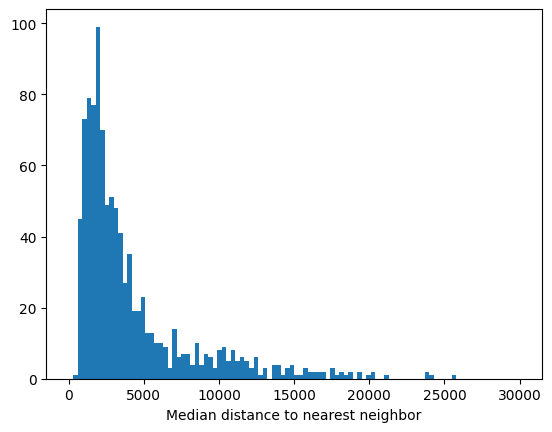

In [33]:
# For each entry in the database, find the N nearest neighbors
all_embeddings = collection.get(include=["embeddings"])
all_nn = collection.query(query_embeddings=all_embeddings["embeddings"], n_results=5)

# Calculate the median distance to the nearest neighbor for each entry
median_dist_all_nn = np.median(all_nn["distances"], axis=1)

# Choose a threshold, plot histogram of values lower to exclude outliers due to instrumental defects
plt.figure()
plt.hist(median_dist_all_nn, bins=100, range=(0, 30_000))
plt.xlabel("Median distance to nearest neighbor")
plt.show()

## Examine some of the objects

We'll make cuts in the median distance to select a small set of objects.
First we create the anomalous objects list by selecting a range of values in the tail of the histogram.
Then we create a "common" objects list by selecting a range near the most populous part of histogram.
The lists will be sorted by increasing median distance to nearest neighbors.

In [34]:
# Find the indexes of the objects that are well separated from their nearest neighbors
indexes = [(i, x) for i, x in enumerate(median_dist_all_nn) if 18_000 < x and x < 30_000]

print(f"Number of well separated objects: {len(indexes)}")
print("Object ID : Rounded median distance to nearest neighbor")

# Use the indexes to gather metadata: object ID, rounded median distance, and file name
anom_objects = []
for indx in sorted(indexes, key=lambda x: x[1]):
    object_id = all_embeddings["ids"][indx[0]]

    found_files = glob.glob(
        f"/home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/{object_id}*.fits"
    )
    file_name = found_files[0][:-11]

    print(f"{object_id} : {np.round(indx[1])} : {file_name}")
    anom_objects.append((object_id, np.round(indx[1]), file_name))

Number of well separated objects: 15
Object ID : Rounded median distance to nearest neighbor
38540785951465862 : 18114.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/38540785951465862_coadd_31.08981_-3.71128_8763
37498191230291738 : 18163.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/37498191230291738_coadd_38.85149_-4.52043_8526
36420240338337867 : 18426.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/36420240338337867_coadd_33.58983_-6.69964_8281
39983753228988234 : 18690.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/39983753228988234_coadd_158.50137_-2.36080_9091
36443209823439043 : 18755.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/36443209823439043_coadd_39.80290_-5.95680_8286
36416267493596417 : 19226.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/36416267493596417_coadd_31.58032_-6.04909_8280
39618298756751866 : 19422.0 : 

In [35]:
# Find the indexes of the objects that are very close to their nearest neighbors
indexes = [(i, x) for i, x in enumerate(median_dist_all_nn) if x < 750]
print(f"Number of close neighbors: {len(indexes)}")
print("Object ID : Rounded median distance to nearest neighbor")

# Use the indexes to gather metadata: object ID, rounded median distance, and file name
common_objects = []
for indx in sorted(indexes, key=lambda x: x[1]):
    object_id = all_embeddings["ids"][indx[0]]

    found_files = glob.glob(
        f"/home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/{object_id}*.fits"
    )
    file_name = found_files[0][:-11]

    print(f"{object_id} : {np.round(indx[1])} : {file_name}")
    common_objects.append((object_id, np.round(indx[1]), file_name))

Number of close neighbors: 12
Object ID : Rounded median distance to nearest neighbor
39913401664672536 : 437.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/39913401664672536_coadd_134.67226_-1.60297_9075
36433576211777886 : 605.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/36433576211777886_coadd_37.88820_-6.54035_8284
37476591839745889 : 615.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/37476591839745889_coadd_30.82134_-5.33058_8521
38553975796029667 : 615.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/38553975796029667_coadd_35.59511_-3.93797_8766
37481144505079428 : 635.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/37481144505079428_coadd_32.16847_-4.59919_8522
36438262021098771 : 644.0 : /home/drew/code/fibad/docs/notebooks/data/hsc_example/hsc_8asec_1000/36438262021098771_coadd_39.06850_-5.95194_8285
39613647307163181 : 665.0 : /home/drew/code/fibad

The following is the requisite plotting code for displaying the samples defined above.

In [142]:
def plot_grid(data_list):
    """
    Plots an n x 4 grid of matplotlib plots.

    Parameters
    ----------
    data_list : list of tuples
        Each tuple in the list is (object id, rounded median distance to NN, file name)
    """
    num_plots = len(data_list)
    num_rows = (num_plots + 2) // 4  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

    for i, data in enumerate(data_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        plotter(ax, data)
        fig.patch.set_facecolor("darkslategrey")

    # Hide any unused subplots
    for j in range(num_plots, num_rows * 4):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()


def plotter(ax, data_tuple):
    """Plot the R band image for a given object ID.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to plot the image on
    data_tuple : (int, float, str)
        Each tuple is (object id, rounded median distance to NN, file name)
    """
    # Read the FITS files
    object_id, dist, file_name = data_tuple

    fits_file = file_name + "_HSC-R.fits"
    data = fits.getdata(fits_file)

    # Normalize the data
    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    title = f"Obj ID: {object_id}\nMedian dist: {np.round(dist)}"

    # Display the image
    ax.imshow(data, origin="lower", norm=LogNorm(), cmap="Greys")
    ax.set_title(title, y=1.0, pad=-30)
    ax.axis("off")  # Hide the axis

Finally, we plot the "common" objects (those with very close nearest neighbors) followed by the "anomalous" objects (those objects with larger distances between nearest neighbors)

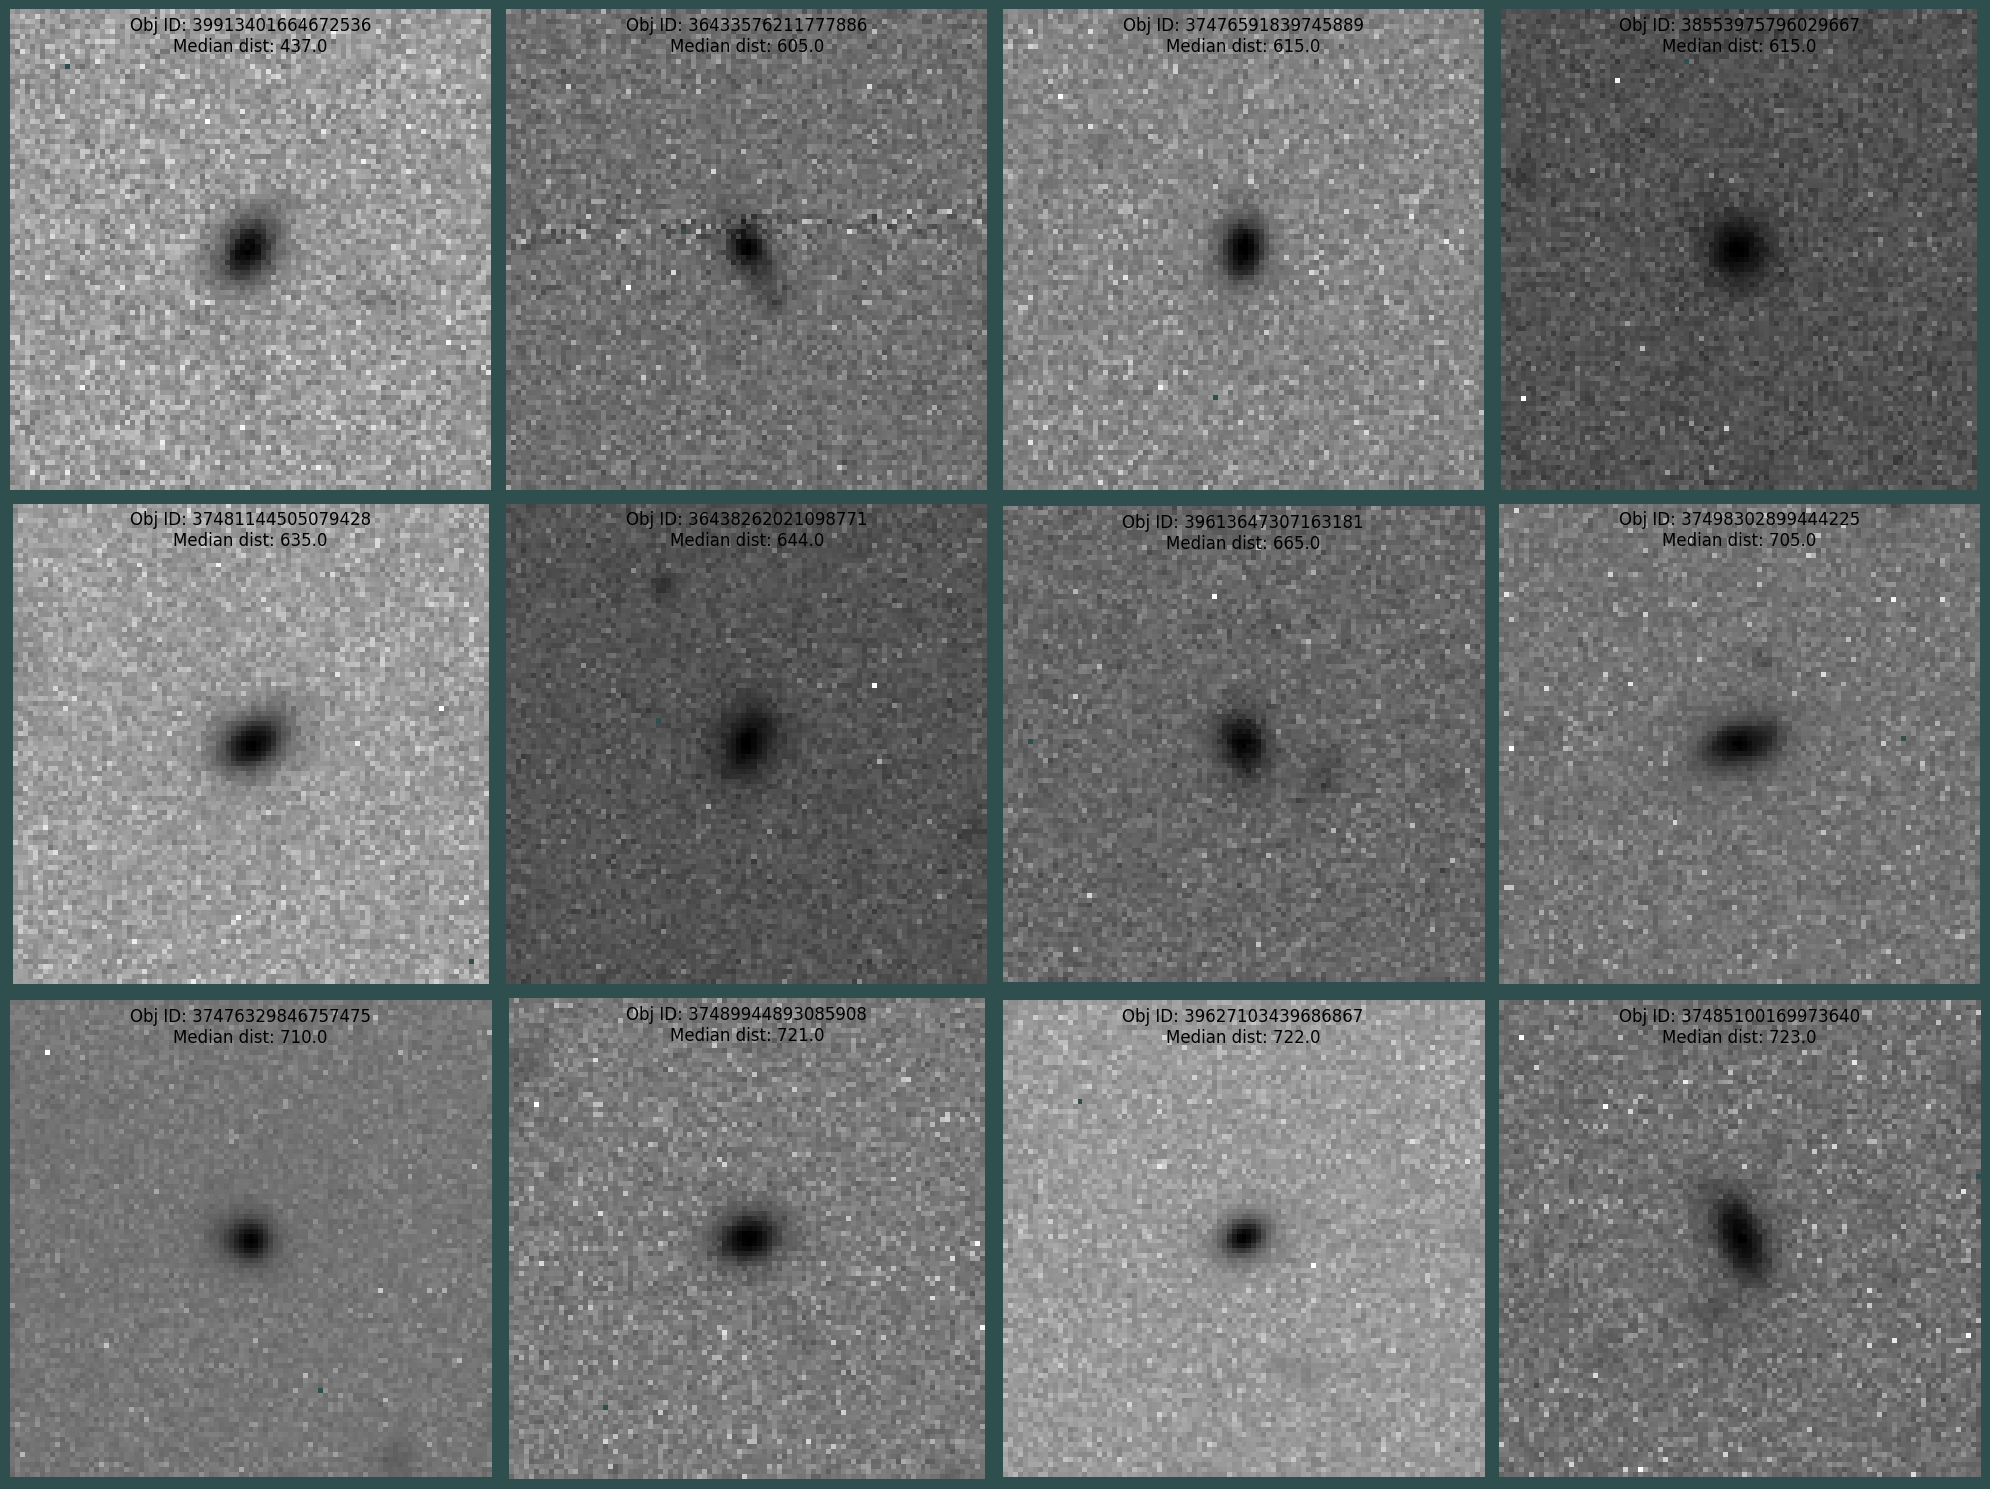

In [157]:
plot_grid(common_objects)

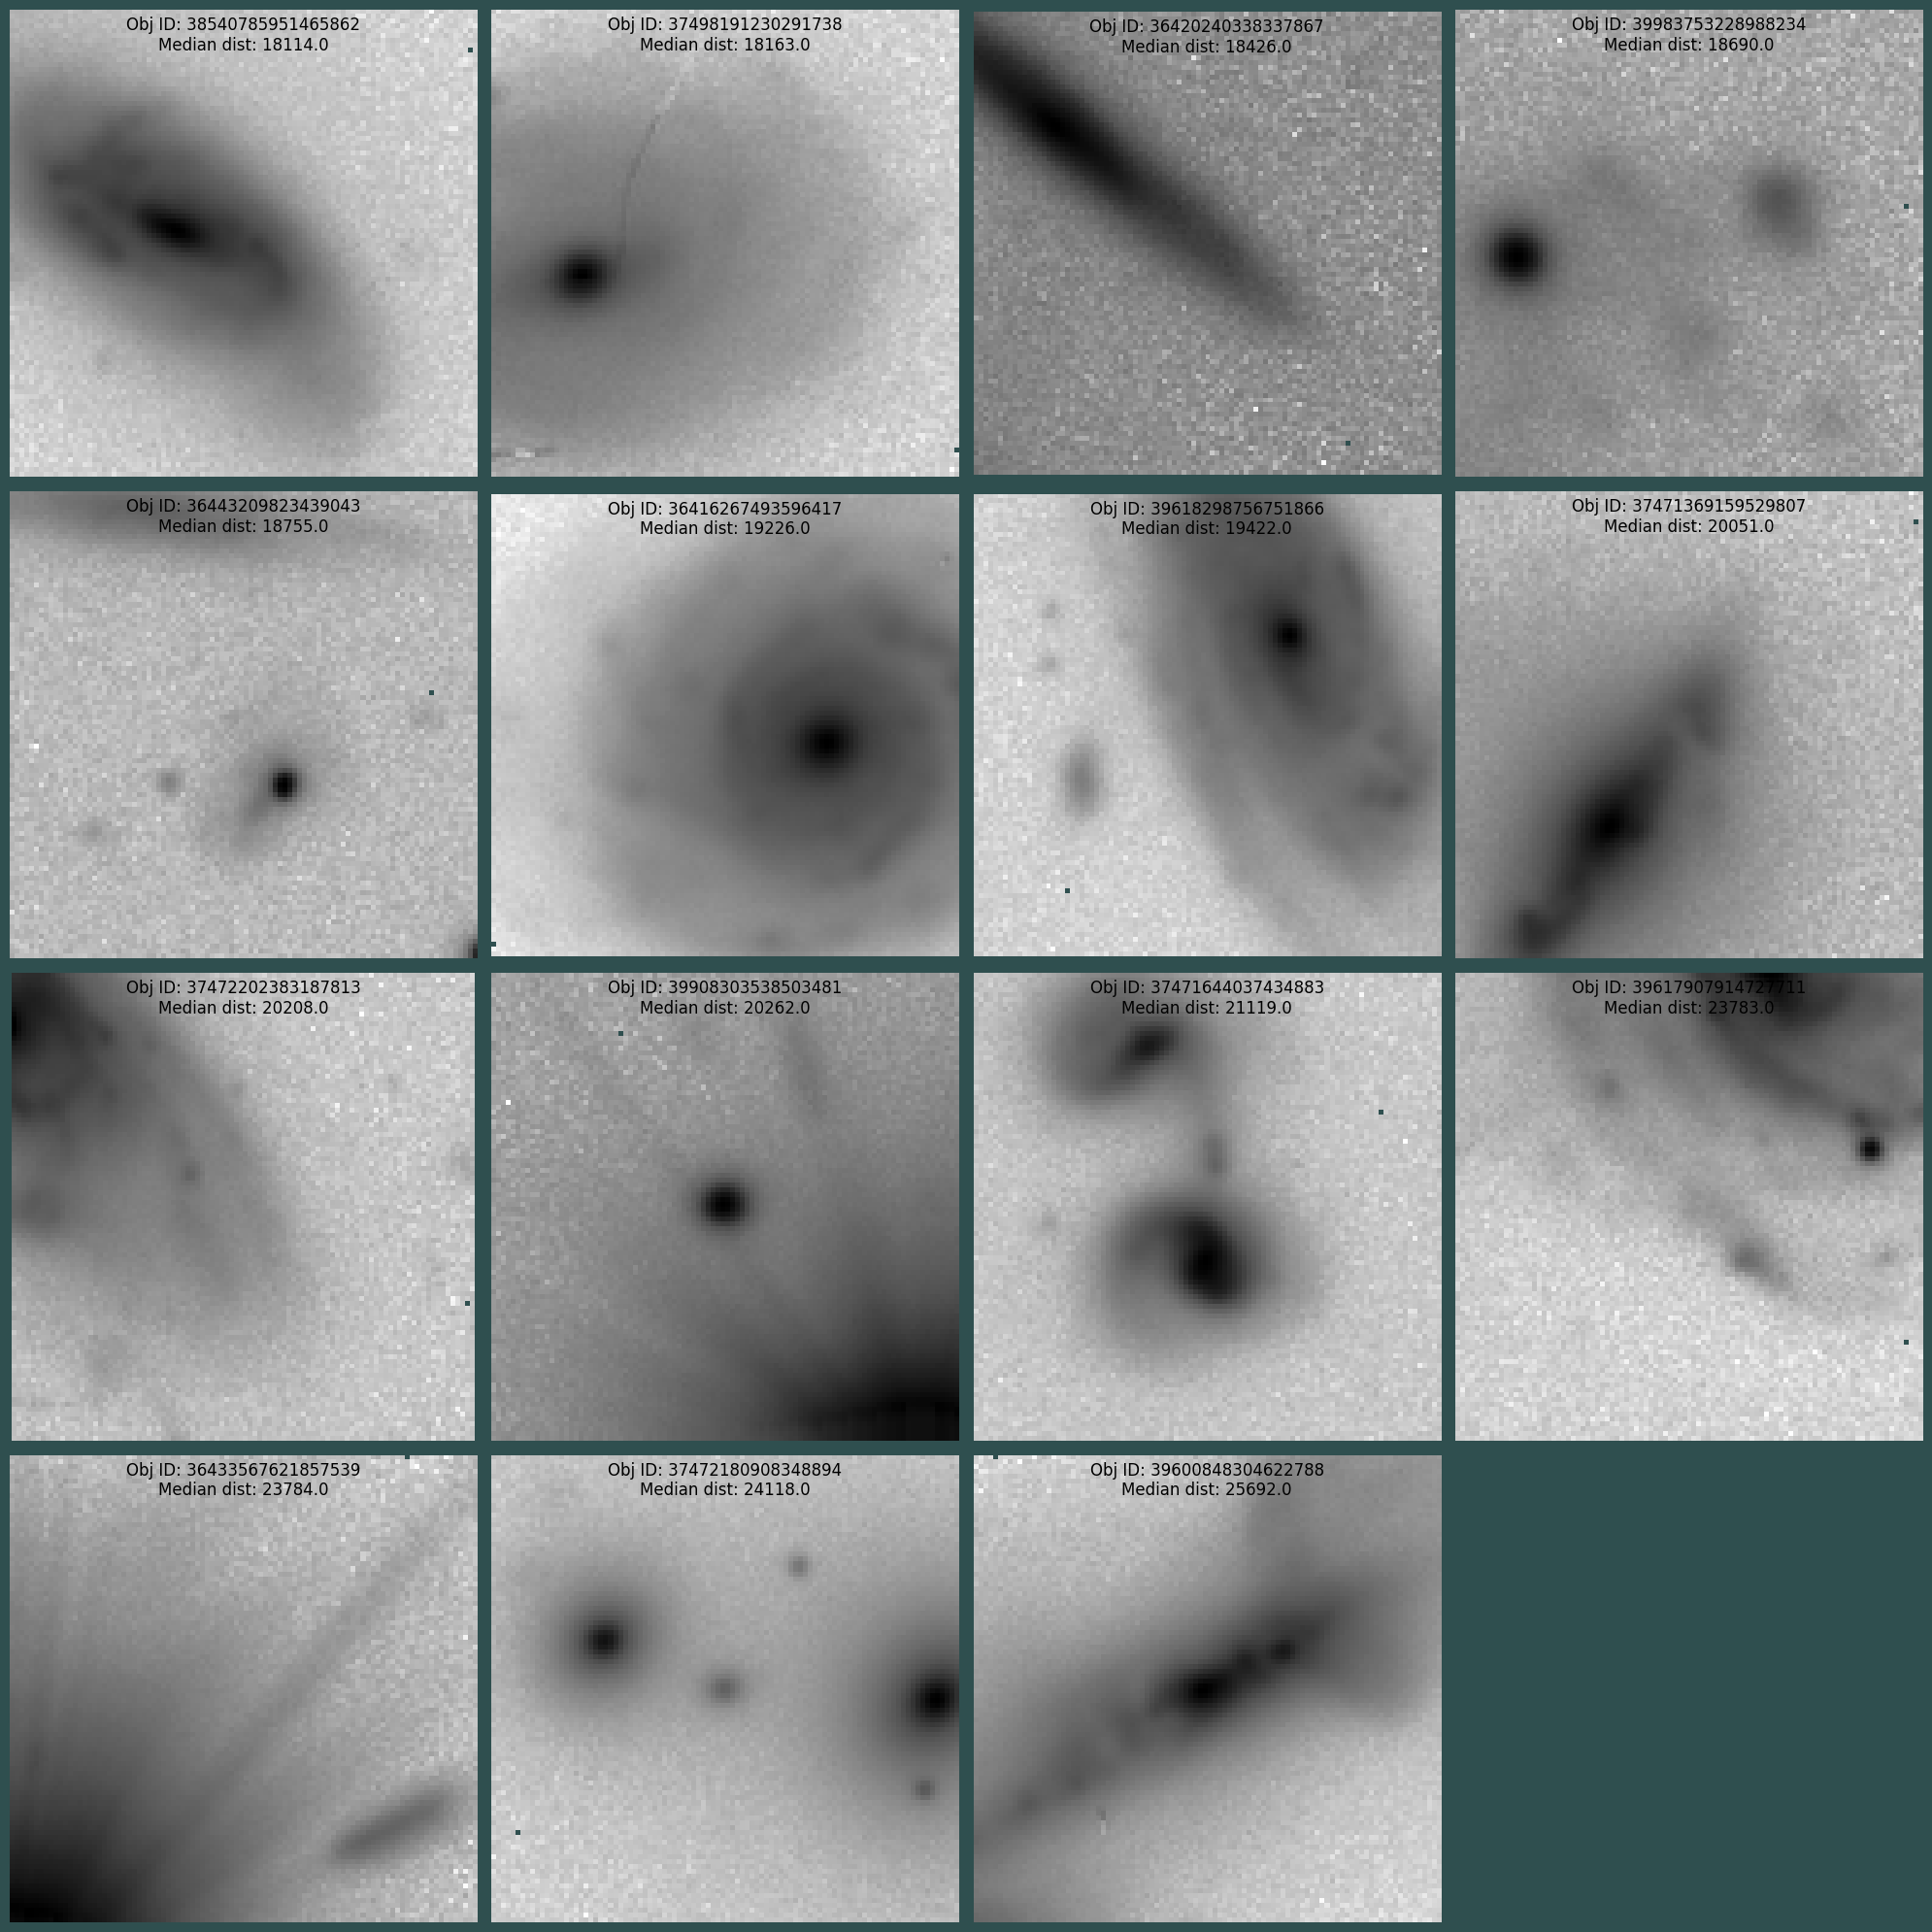

In [143]:
plot_grid(anom_objects)